In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
# Here are the units we'll need

s = UNITS.second
N = UNITS.newton
kg = UNITS.kilogram
m = UNITS.meter
y = UNITS.year

<Unit('year')>

# Question
How does mass and initial velocity affect the shape of the orbit of a binary star?

A binary star is a system containing two stars in close proximity.  In this system, both stars orbit around a common center or one star orbits around the other.  We wanted to create a model to understand how the masses of the two stars affected the shape of the stars orbit.  We also wanted to understand the shape of the binary star’s orbit when the star’s velocities are not constant.  

<function matplotlib.pyplot.show(*args, **kw)>

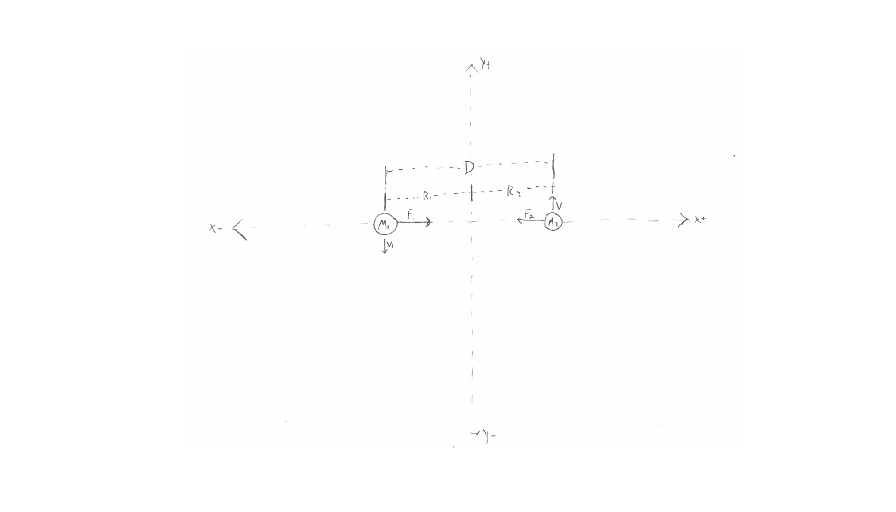

In [3]:
plt.figure(figsize = (15,15))
myImage = mpimg.imread("Untitled-1.png")
myImage = plt.imshow(myImage)
plt.axis('off')
plt.show

## Creating the Model

The code below calculates the the initial velocity and distance from the origin of one star in a binary star system. To do so, Kepler's Third Law, Newton's Law of Universal Gravitation, and centripetal acceleration are used. The model itself also assumes that no other masses exert a force on the system.

### Calculating Initial Distance and Velocity from Origin
Modifying Kepler's Third Law gives the formula:

$ D= \sqrt[3]{\frac{p^2 G (m_{1}+m_{2})} {4 \pi^2}} $

This allows for the distance between stars to be calculated by hand picking masses for each sun and a desired period. From here, the radius from the origin to mass one can be calculated by the formula:

$ r = \frac{m_{2} D} {m_{1}+m_{2}} $

Then, to calculate the initial velocity, the Newton's Law of Universal Gravitation can be used to calculate the force exerted on each star. Dividing the given force by mass one gives the velocity of mass one, which then can be plugged into the formula:

$ v = \sqrt{r a} $

Repeating this process with the masses switched allows the same values for the second mass to be calculated.

In [4]:
def init_r(p, m1, m2):
    """distance of m1 from origin
    
    p: orbital period
    m1: mass 1
    m2: mass 2
    
    returns: radius to origin of m1
    """
    G = 6.674e-11 * N / kg**2 * m**2
    
    d=((p**2)*G*(m1+m2)/(4*pi**2))**(1/3)
    r = m2*d/(m1+m2)
    return r

def init_v(p, m1, m2):
    """initial velocity of m1
    
    p: orbital period
    m1: mass 1
    m2: mass 2
    
    returns: initial velocity of m1
    """
    G = 6.674e-11 * N / kg**2 * m**2
    
    d=((p**2)*G*(m1+m2)/(4*pi**2))**(1/3)
    F = G*m1*m2/d**2
    a = F/m1
    r = d/2
    v = ((r)*a)**(1/2)
    return v


### Making the System
The make_sys function takes inputs for the mass of both stars as well as the orbital period, eccentricity, and end time. It then creates a system with those values as well as a State that hold the initial position and velocity of each star.

In [5]:
def make_sys(sun1, sun2, p, e, t_end):
    """Computes gravitational force.
    
    sun1: mass of sun 1
    sun2: mass of sun 2
    re: distance from earth to origin
    ve: initial velocity of earth
    p: period of binary star orbit
    e: factor to multiply initial velocities of sun by
    
    returns: force vector
    """
    init = State(x1=init_r(p, sun1, sun2),y1=0,
                 vx1=0,vy1=-init_v(p, sun1, sun2)*e,
                 x2=-init_r(p, sun2, sun1),y2=0,
                 vx2=0, vy2=init_v(p, sun2, sun1)*e)
    
    system = System(init=init,
                    m1=sun1,
                    m2=sun2,
                    t_0=0 * s,
                    t_end=t_end)
    return system

In [6]:
sun1=1.989e30 * kg
sun2=1.989e30 * kg

p = 12.154e7 * s
e = 1
t_end = 12.154e8 * s

system = make_sys(sun1, sun2, p, e, t_end)

,values
init,x1 231568726427.43024 meter ** 0.666667 * ...
m1,1.989e+30 kilogram
m2,1.989e+30 kilogram
t_0,0 second
t_end,1215400000.0 second


### Updating the State
The fg function calculates a force vector based on the Law of Universal Gravitation to be used in the slope function. This makes the assumption that each planet is a point mass.

In [7]:
def fg(r, m1, m2):
    """Computes gravitational force.
    
    r: distance between masses
    m1: mass 1
    m2: mass 2
    
    returns: force vector
    """
    G = 6.674e-11 * N / kg**2 * m**2

    direction = r.hat()
    radius = r.mag
    
    force = direction * G * m1 * m2 / radius**2
    return force

The slope function below returns the derivatives of each value in the state, which means that it returns velocities and accelerations of each star in each direction. The derivative for position is velocity; these are already stored in the State. To calculate acceleration, the derivative of velocity, Newton's Law of Universal Gravitation:

$ F = {\frac{G m_{1} m_{2}} {r}} $   

As well as Newton's Second Law of Motion were used:
                
$ F = m a $

By substituting for force, we get:

$ m_{1} a = {\frac{G m_{1} m_{2}} {r}} $

Then, divide by $m_{1}$ on both sides to get acceleration.

$a = {\frac{G m_{2}} {r}} $

The function below accomplishes this with the use of the fg function seen above.

In [8]:
def slope_func(state, t, system):
    """Compute derivatives of the state.
    
    state: position, velocity
    t: time
    system: System object containing `g`
    
    returns: derivatives of y and v
    """
    x1, y1, vx1, vy1, x2, y2, vx2, vy2 = state
    unpack(system)    
    
    xy1 = Vector(x1,y1)
    xy2 = Vector(x2,y2)
    
    r1 = xy1.hat()*(xy1.mag+xy2.mag)
    r2 = xy2.hat()*(xy1.mag+xy2.mag)
    
    force1 = fg(r1, m1, m2)
    force2 = fg(r2, m1, m2)
    
    a1 = force1 / m1 * -1
    a2 = force2 / m2 * -1
    
    return (vx1, vy1, a1.x, a1.y, vx2, vy2, a2.x, a2.y)

In [9]:
results, details = run_ode_solver(system, slope_func, max_step=1000000)
details

,values
sol,None
t_events,[]
nfev,7376
njev,0
nlu,0
status,0
message,The solver successfully reached the end of the...
success,True


The plot_results function serves to quickly and cleanly plot our results.

In [10]:
def plot_results(results):
    """Compute derivatives of the state.
    
    results: dataframe of binary star
    
    plots what you want
    """
    plot(results.x1, results.y1, 'orange', label = 'Star One')
    plot(results.x2, results.y2, 'r', label = 'Star Two')
    title = 'Binary Star Orbit'
        
    decorate(xlabel = 'X Position (m)',
             ylabel = 'Y Position (m)',
             title = title)

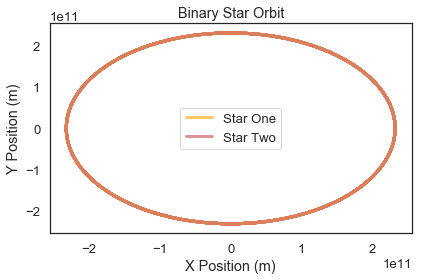

In [11]:
plot_results(results)

###### Note: the orbits are overlapping, so only one line can be seen.

## Results and Interpretations

### System of Two Binary Stars with Identical Orbits and Identical Masses
Here we run our model with identical masses and constant.

In [99]:
sun1=1.989e30 * kg
sun2=1.989e30 * kg

p = 12.154e7 * s
e = 1
t_end = p

system = make_sys(sun1, sun2, p, e, t_end)

results, details = run_ode_solver(system, slope_func, max_step=1000000)

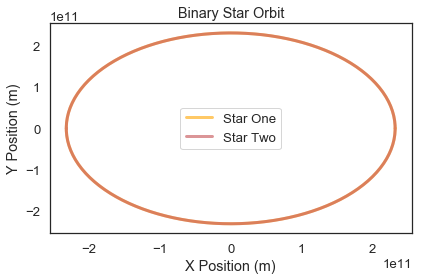

In [100]:
plot_results(results)

As seen in the graph, both stars follow a circular orbit both identical in shape and position. Each star is on opposite to one another while orbiting. Because the orbits are circular, it means that the stars have a constant velocity throughout. This plot acts as a control as it follows expections of a binary star.

### System of Two Binary Stars with Different Masses
Here we run our model with constant velocities, but different masses.

In [101]:
sun1=1.989e30 * kg
sun2=1e30 * kg

p = 12.154e7 * s
e = 1
t_end = p*5

system = make_sys(sun1, sun2, p, e, t_end)

results, details = run_ode_solver(system, slope_func, max_step=1000000)

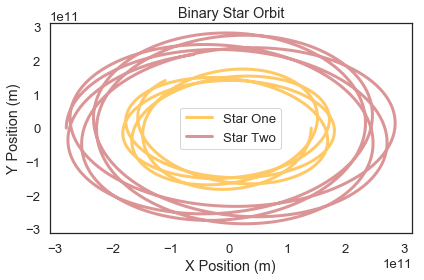

In [102]:
plot_results(results)

As seen in the graph, both stars follow a mostly circular orbit of different sizes. Each star is on opposite to one another while orbiting. Because the orbits are mostly circular, it means that the stars have a constant velocity throughout. It appears that the the smaller mass will have a larger orbit that encapsulates the larger mass' orbit. This makes sense because the smaller mass will have a greater acceleration than the larger mass. We think that the orbits are not perfectly aligned because of slight inaccuracies in either the initial velocity or position.

### System of Two Binary Stars with Overlapping Orbits and Identical Masses
Here we run our model with identical masses, but non-constant velocities.

In [16]:
sun1=1.989e30 * kg
sun2=1.989e30 * kg

p = 12.154e7 * s
e = .6
t_end = p

system = make_sys(sun1, sun2, p, e, t_end)

results, details = run_ode_solver(system, slope_func, max_step=1000000)

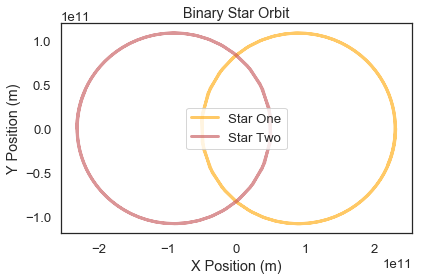

In [17]:
plot_results(results)

As seen in the graph, both stars follow ellpitical orbits. Each star is on opposite to one another while orbiting. Because the orbits are elliptical, it means that their velocities constantly change throughout the orbit. It appears that smaller than calculated initial velocities lead to a shorter period, while larger ones lead to longer periods. This makes sense because with increased initial velocities, the orbit becomes larger. With smaller or larger than calculated initial velocities, the orbits themselves begin to misalign.

### System of Two Binary Stars with Overlapping Orbits and Different Masses
Here we run our model with different masses and non-constant velocities.

In [105]:
sun1=1.989e30 * kg
sun2=1.25e30 * kg

p = 12.154e7 * s
e = 1.2
t_end = 12.154e8 * s

system = make_sys(sun1, sun2, p, e, t_end)

results, details = run_ode_solver(system, slope_func, max_step=1000000)

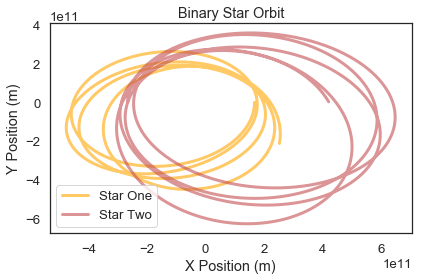

In [106]:
plot_results(results)

As seen in the graph, changing the mass and initial calculated velocities follows the patterns seen above, where the larger mass has a smaller orbit, while both orbits are elliptical and misaligned. 

## Conclusion
It appears that different mass ratios affect the relative size, while initial velocity of the orbit affects the overal eccentricity of the orbit. This model could be expanded to include orbiting planets or additional stars. By doing so it could give insight into conditions on planets orbiting binary stars.

#### Modeling Process
We started with a model of the earth orbiting a stationary sun, then exanded it to involve two stars orbiting a center of mass. Initially, everything was hard coded, and one star was fixed. Later, we improved our model by having both stars move as well utilizing Python functions wherever possible.

#### Errors
For the most part, the model acts as predicted, but slight errors in the plots suggest that our initial velocities or positions are slightly inaccurate. We assumed that each star was a point mass and that no outside objects affected the system, which may also have contributed to the imperfect orbits. Still, the models followed general expectations.